# Customization & Components

## Customize the activation function

Modification based on [Ref](https://medium.com/@chinesh4/custom-activation-function-in-tensorflow-for-deep-neural-networks-from-scratch-tutorial-b12e00652e24)

In [2]:
# !pip install tensorflow --upgrade

In [ ]:
customize activation    

#work/python/keras-1

#work/DNN/Comparison-activation

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
tf.__version__

'2.4.1'

### Example 1

[Gaussin Radial Basis Function](https://en.wikipedia.org/wiki/Radial_basis_function) is defined as
$$
\phi(x) = e^{-(\epsilon r)^2}
$$

We found out that radial basis function works pretty good as an activation in a network, this will be demonstrated in the following tutorials. The raial basis function only makes a difference in an interval close to the center which is similar to the idea of "on-and-off" of an activation function.

In a dimension 1 space, let us set activation to be $\phi(x)=e^{-x^2}$. Since this is not in TensorFlow's list of activation functions https://www.tensorflow.org/api_docs/python/tf/keras/activations, we will use it for demonstration of customizing activation function.

In [2]:
#######################################
#define the activation function
def rbf(x):
    return tf.math.exp(-x**2)

#######################################
#define the derivative of the activation function
def d_rbf(x):
    return tf.gradients(rbf,x)

#######################################
#we couldn't use “d_rbf” as an activation function if we wanted to 
#because tensorflow doesn't know how to calculate the gradients of that function.
def rbf_grad(op, grad):
    x = op.inputs[0]
    n_gr = d_rbf(x)    #defining the gradient.
    return grad * n_gr

def py_func(func, inp, Tout, stateful=True, name=None, grad=None):
    # Need to generate a unique name to avoid duplicates:
    rnd_name = 'PyFuncGrad' + str(np.random.randint(0, 1E+2))
    tf.RegisterGradient(rnd_name)(grad)
    g = tf.get_default_graph()
    with g.gradient_override_map({"PyFunc": rnd_name, "PyFuncStateless": rnd_name}):
        return tf.py_func(func, inp, Tout, stateful=stateful, name=name)
    
def tf_rbf(x,name=None):
    with tf.name_scope(name, "rbf", [x]) as name:
        y = py_func(rbf,   #forward pass function
                    [x],
                    [tf.float32],
                    name=name,
                    grad= rbf_grad) #the function that overrides gradient
        y[0].set_shape(x.get_shape())     #when using with the code, it is used to specify the rank of the input.
    return y[0]

In [3]:
## Training data
np.random.seed(1)
x_train = np.linspace(-40,40,20)
y_train = 0.3*x_train**2 + np.random.normal(0, 1, len(x_train)) 

In [4]:
model_rbf = tf.keras.Sequential()
model_rbf.add(tf.keras.layers.Dense(3,activation=rbf))     #no need to put quote around rbf
model_rbf.add(tf.keras.layers.Dense(1))

model_rbf.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.1))
model_rbf.fit(x_train,y_train, epochs=1000, verbose=0)

# model.summary()
model_rbf.get_weights()   #test if model is trained successfully

[array([[-2.6122294e-03,  1.6906145e-03, -2.2995217e+00]], dtype=float32),
 array([-4.2092835e-04,  2.8977118e-04,  4.8410983e+00], dtype=float32),
 array([[  57.36145 ],
        [  59.288876],
        [-115.397705]], dtype=float32),
 array([55.409958], dtype=float32)]

## Cutomize the loss function 

In [9]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(3,activation=rbf))     #no need to put quote around rbf
model.add(tf.keras.layers.Dense(1))

In [12]:
# customize loss
def custom_loss(ytrue,ypred):
    val = tf.math.reduce_mean(tf.math.square((ytrue-ypred)/10))
    return val

In [16]:
model.compile(loss=custom_loss,optimizer=tf.keras.optimizers.Adam(0.01))
model.fit(x_train,y_train,epochs=100,verbose=0)

model.get_weights()    #test if model is trained successfully

[array([[ 4.8343139e-05, -1.8820183e-01,  5.0299735e-05]], dtype=float32),
 array([1.9036455e-05, 5.2888556e-03, 2.9459905e-05], dtype=float32),
 array([[ 5.030023 ],
        [-4.4802723],
        [ 4.8218493]], dtype=float32),
 array([3.9862227], dtype=float32)]

- [Models](#Models)
- [Layers](#Layers)
- [Activations](#Activations)
- [Fully Connected Networks](#Fully-Connected-Networks)

[Ref](https://www.dbooks.org/tensorflow-2-tutorial-1589/)

## Components
### Models

In [3]:
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from functools import reduce
from matplotlib import pyplot as plt
from pprint import pprint

In [4]:
print(tf.__version__)
## Generate Needed Data
## Ax = b Problem
tf.random.set_seed(42)
true_weights = tf.constant(list(range(5)), dtype=tf.float32)[:, tf.newaxis]    #x
x = tf.constant(tf.random.uniform((32, 5)), dtype=tf.float32)           #A
y = tf.constant(x @ true_weights, dtype=tf.float32)            #b

2.4.1


In [7]:
weights = tf.Variable(tf.random.uniform((5, 1)), dtype=tf.float32)
y_hat = tf.linalg.matmul(x, weights)

In [6]:
# np.all(tf.matmul(x, weights) == tf.linalg.matmul(x, weights))

True

#### Trial 1: Define this linear regression model using class.

With the class, we can evaluate `Ax` and access `x`

In [8]:
class LinearRegression(object):
    def __init__(self, num_parameters):
        self._weights = tf.Variable(tf.random.uniform((num_parameters,1)), dtype=tf.float32)
    
    @tf.function
    def __call__(self, x):
        return tf.linalg.matmul(x, self._weights)
    
    @property
    def variables(self):
        return self._weights

In [10]:
# model = LinearRegression(5)
# model(x)

Note that we decorated the `__call__` method with `tf.function`, hence a graph will
be generated to back up the computation.

With this class, we can rewrite the training code as:

#### Trial 1: Train the model

Gradient descent method

In [9]:
model = LinearRegression(5)

@tf.function
def train_step():
    with tf.GradientTape() as tape:
        y_hat = model(x)
        loss = tf.reduce_mean(tf.square(y - y_hat))
    gradients = tape.gradient(loss, model.variables)
    model.variables.assign_add(tf.constant([-0.05], dtype=tf.float32)* gradients)
    return loss

t0 = time.time()
for iteration in range(1001):
    loss = train_step()
    if not (iteration % 200):
        print('mean squared loss at iteration {:4d} is {:5.4f}'.format(iteration, loss))

pprint(model.variables)
print('time took: {} seconds'.format(time.time() - t0))

mean squared loss at iteration    0 is 18.7201
mean squared loss at iteration  200 is 0.0325
mean squared loss at iteration  400 is 0.0017
mean squared loss at iteration  600 is 0.0002
mean squared loss at iteration  800 is 0.0000
mean squared loss at iteration 1000 is 0.0000
<tf.Variable 'Variable:0' shape=(5, 1) dtype=float32, numpy=
array([[-3.1365452e-03],
       [ 1.0065703e+00],
       [ 2.0000944e+00],
       [ 3.0032609e+00],
       [ 3.9934685e+00]], dtype=float32)>
time took: 0.35858607292175293 seconds


Here, we still decorated the `train_step` function with `tf.function`. The reason is
that <font color=red>the loss and gradient calculation can also benefit from graphs</font>.
This simple model class works fine. But it can be better if we subclass from
`tf.keras.Model`.

#### Trial 2: Define this linear regression model using class as subclass from tf.keras.Model

In [10]:
class LinearRegression(tf.keras.Model):
    def __init__(self, num_parameters, **kwargs):
        super().__init__(**kwargs)
        self._weights = tf.Variable(tf.random.uniform((num_parameters,1)), dtype=tf.float32)
    
    @tf.function
    def call(self, x):
        return tf.linalg.matmul(x, self._weights)

This model class has a few differences compared with the organic version. First is that we
implemented the call method rather than the dunder version of it. Under the hood,
`tf.keras.Model`'s `__call__` method is a wrapper over this `call` method, and it is
performing, among many other things, things like converting inputs to tensors and graph
building. The second thing is that we dropped the accessor for the variables because we
inherited one.


With this subclass model, we need to modify the training code a bit to make it work. The
`.variables` accessor from `tf.keras.Model` gives us a collection of references to
the model's variables, to accommodate complex models with many sets of variables. So,
as a result, the corresponding gradients will be a collection too.

In [11]:
model = LinearRegression(5)
# model(x)
model.get_weights()   #only the value in model.variables

[array([[0.7402308 ],
        [0.33938193],
        [0.5692506 ],
        [0.44811392],
        [0.29285502]], dtype=float32)]

In [12]:
model.variables   #this is a list

[<tf.Variable 'Variable:0' shape=(5, 1) dtype=float32, numpy=
 array([[0.7402308 ],
        [0.33938193],
        [0.5692506 ],
        [0.44811392],
        [0.29285502]], dtype=float32)>]

#### Trial 2: Train the model

In [13]:
model = LinearRegression(5)

@tf.function
def train_step():
    with tf.GradientTape() as tape:
        y_hat = model(x)
        loss = tf.reduce_mean(tf.square(y - y_hat))
    gradients = tape.gradient(loss, model.variables)
    for g, v in zip(gradients, model.variables):      #if use the above way to update variables, error; see below
        v.assign_add(tf.constant([-0.05], dtype=tf.float32) * g)
    return loss

t0 = time.time()
for iteration in range(1001):
    loss = train_step()
    if not (iteration % 200):
        print('mean squared loss at iteration {:4d} is {:5.4f}'.format(iteration, loss))
        
pprint(model.variables)
print('time took: {} seconds'.format(time.time() - t0))

mean squared loss at iteration    0 is 14.3411
mean squared loss at iteration  200 is 0.0294
mean squared loss at iteration  400 is 0.0016
mean squared loss at iteration  600 is 0.0002
mean squared loss at iteration  800 is 0.0000
mean squared loss at iteration 1000 is 0.0000
[<tf.Variable 'Variable:0' shape=(5, 1) dtype=float32, numpy=
array([[-3.2304246e-03],
       [ 1.0066777e+00],
       [ 2.0000989e+00],
       [ 3.0033290e+00],
       [ 3.9933815e+00]], dtype=float32)>]
time took: 0.27019238471984863 seconds


In [54]:
## Uncomment the following to see the error message

# model = LinearRegression(5)

# @tf.function
# def train_step():
#     with tf.GradientTape() as tape:
#         y_hat = model(x)
#         loss = tf.reduce_mean(tf.square(y - y_hat))
#     gradients = tape.gradient(loss, model.variables)    #model.variables is a list
#     model.variables.assign_add(tf.constant([-0.05], dtype=tf.float32) * gradients)
#     return loss

# t0 = time.time()
# for iteration in range(1001):
#     loss = train_step()
#     if not (iteration % 200):
#         print('mean squared loss at iteration {:4d} is {:5.4f}'.format(iteration, loss))
        
# pprint(model.variables)
# print('time took: {} seconds'.format(time.time() - t0))

Through subclassing `tf.keras.Model` , we get to use many methods from it, like print
out a summary and the Keras model training/testing methods.

In [15]:
print(model.summary())
model.compile(loss='mse', metrics=['mae'])
print(model.evaluate(x, y, verbose=-1))    

Model: "linear_regression_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________
None
[4.5830074668629095e-06, 0.0017235130071640015]


In [29]:
## MSE
# tf.reduce_mean(tf.keras.losses.MSE(model(x),y))
tf.reduce_mean(tf.square(model(x) - y))

<tf.Tensor: shape=(), dtype=float32, numpy=4.5830075e-06>

In [30]:
## MAE
tf.reduce_mean(tf.math.abs(model(x) - y))

<tf.Tensor: shape=(), dtype=float32, numpy=0.001723513>

Let's also try using the `.fit` API to train our linear regression model.

In [31]:
model = LinearRegression(5)
model.compile(optimizer='SGD', loss='mse')
model.optimizer.lr.assign(.05)
t0 = time.time()
history = model.fit(x, y, epochs=1001, verbose=0)
pprint(history.history['loss'][::200])
pprint(model.variables)
print('Time took: {} seconds'.format(time.time() - t0))

[18.954912185668945,
 0.02976365201175213,
 0.0010764360195025802,
 3.935765562346205e-05,
 1.450204877073702e-06,
 5.471034825177412e-08]
[<tf.Variable 'Variable:0' shape=(5, 1) dtype=float32, numpy=
array([[5.6911039e-04],
       [1.0001738e+00],
       [1.9999688e+00],
       [2.9999278e+00],
       [3.9994378e+00]], dtype=float32)>]
Time took: 0.8120768070220947 seconds


Not surprisingly we recovered the ground truth, but it took significantly more time
compared to our custom training loop, it is probably due to the convenient `.fit` API is
doing a bunch more stuff than updating parameters.

#### Trial 3: Define this linear regression model using class as subclass from tf.keras.Model

Now, let's spice up the model a bit by adding a additional useless bias term and initialize it
with a large value. Ideally, after training, this bias term would become an insignificantly
small number.

In [39]:
### Ax + c = b 
class LinearRegressionV2(tf.keras.Model):
    def __init__(self, num_parameters, **kwargs):
        super().__init__(**kwargs)
        self._weights = tf.Variable(tf.random.uniform((num_parameters,1)), dtype=tf.float32)
        self._bias = tf.Variable([100], dtype=tf.float32)
    
    @tf.function
    def call(self, x):
        return tf.linalg.matmul(x, self._weights) + self._bias
    
model = LinearRegressionV2(5)
@tf.function
def train_step():
    with tf.GradientTape() as tape:
        y_hat = model(x)      ##here is the key!!!
        loss = tf.reduce_mean(tf.square(y - y_hat))
    gradients = tape.gradient(loss, model.variables)
    for g, v in zip(gradients, model.variables):      #if use the above way to update variables, error; see below
        v.assign_add(tf.constant([-0.05], dtype=tf.float32) * g)
    return loss

t0 = time.time()
for iteration in range(1001):
    loss = train_step()

pprint(model.variables)

[<tf.Variable 'Variable:0' shape=(5, 1) dtype=float32, numpy=
array([[-2.8140063],
       [-4.8734136],
       [-2.0642996],
       [-1.3286525],
       [ 2.171379 ]], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([9.778882], dtype=float32)>]


Hmm, something is very wrong, the bias term is not updated at all. Guess where might be
the problem? It's in the `train_step` function. Since the input signature has not
changed(there is none), the function is been lazy and did not realize it should do a
retracing. Thus it is training with the old graph, in which the bias term simply does not
exist!

#### Trial 4: Define this linear regression model using class as subclass from tf.keras.Model

To address this issue, we can make `model` as an input to `train_step`, so that when
the function is invoked with a different model it will create or grab a graph accordingly.

In [51]:
@tf.function
def train_step(model):
    with tf.GradientTape() as tape:
        y_hat = model(x)
        loss = tf.reduce_mean(tf.square(y - y_hat))
    gradients = tape.gradient(loss, model.variables)
    for g, v in zip(gradients, model.variables):
        v.assign_add(tf.constant([-0.05], dtype=tf.float32) * g)
    return loss

model = LinearRegression(5)     #Ax=b
for iteration in range(1001):
    loss = train_step(model)
pprint(model.variables)

model = LinearRegressionV2(5)    #Ax+c=b
for iteration in range(5001):
    loss = train_step(model)
pprint(model.variables)

print(train_step._get_tracing_count())

[<tf.Variable 'Variable:0' shape=(5, 1) dtype=float32, numpy=
array([[-8.0306112e-04],
       [ 1.0025039e+00],
       [ 2.0000150e+00],
       [ 3.0011511e+00],
       [ 3.9972730e+00]], dtype=float32)>]
[<tf.Variable 'Variable:0' shape=(5, 1) dtype=float32, numpy=
array([[-2.6643013e-03],
       [ 9.9406248e-01],
       [ 1.9960064e+00],
       [ 2.9956589e+00],
       [ 3.9983623e+00]], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.0096044], dtype=float32)>]
2


### Layers

We typically use the Model class for the overall model architecture, that is how may
combine many smaller computational units to do the job. It is ok to code up small units
with `tf.keras.Model` and then combine them, but since we won't really need many of
the model specific functionalities with these smaller building blocks(for example, its
unlikely we would ever want to call the .fit method on a unit). It is better to use the
`tf.keras.layers.Layer` class. Actually, the Model class is a wrapper over the Layer
class.

Lets say that we want to 'upgrade' the linear regression model to be a composition of a
few linear transformations. We can code up the linear transformation as a Layer class and
then just combine a bunch of its instances of it them in one model.

#### Trial 1: Define the linear regression model using class as subclass from tf.keras.layers.Layer

Define repeated linear regression (All above is just 1 single linear regression)

Note: In trial 1, we need to specify the input, output shape for each linear regression

In [53]:
class Linear(tf.keras.layers.Layer):
    def __init__(self, num_inputs, num_outputs, **kwargs):
        super().__init__(**kwargs)
        self._weights = tf.Variable(tf.random.uniform((num_inputs, num_outputs)), dtype=tf.float32)
    
    @tf.function
    def call(self, x):
        return tf.linalg.matmul(x, self._weights)

class Regression(tf.keras.Model):
    def __init__(self, num_inputs_per_layer, num_outputs_per_layer, **kwargs):
        super().__init__(**kwargs)
        self._layers = [Linear(num_inputs, num_outputs) for (num_inputs, num_outputs) in zip(num_inputs_per_layer, num_outputs_per_layer)]
    
    @tf.function
    def call(self, x):
        for layer in self._layers:
            x = layer(x)
        return x

In `Linear` class definition above, we swapped the super class and generalized it with
the option to specify output size. In the `Regression` model class, we have the option to
use <font color=red> one or a chain of this Linear layers</font>. One obvious benefit with this set up, is that we
now separated the concern of how individual computing units should work and the overall
architecture design of the model. We use Layer to handle the first, and use Model to
tackle the latter.

Let's see if the model is trainable.

In [54]:
model = Regression([5, 3], [3, 1])
for iteration in range(1001):
    loss = train_step(model)    #x,y are in train_step
print('Mean absolute error is: ', tf.reduce_mean(tf.abs(y - model(x))).numpy())

Mean absolute error is:  1.2591481e-06


In [59]:
model.get_weights()

[array([[ 0.37866265, -0.01718613, -0.1357575 ],
        [ 0.63600516,  0.05279344,  0.31817758],
        [ 0.31306508,  0.25236115,  0.93384993],
        [ 0.848499  ,  0.3870639 ,  1.2533945 ],
        [ 0.55826724,  1.226812  ,  1.5695485 ]], dtype=float32),
 array([[0.65006894],
        [0.76955056],
        [1.7157797 ]], dtype=float32)]

In [58]:
model.layers[0].get_weights()

[array([[ 0.37866265, -0.01718613, -0.1357575 ],
        [ 0.63600516,  0.05279344,  0.31817758],
        [ 0.31306508,  0.25236115,  0.93384993],
        [ 0.848499  ,  0.3870639 ,  1.2533945 ],
        [ 0.55826724,  1.226812  ,  1.5695485 ]], dtype=float32)]

One problem with this linear layer is that it needs the complete sizing information and
allocates resources for all the variables upfront. Ideally, we want it to be a bit lazy, it
should calculate variable sizes and occupy resources only when needed. To archive this,
we implement the `build` method which will handle the variable initialization. The
`build` method can be explicitly called, or it will be invoked automatically the first time
there is data flow to it. With this, the constructor now only stores the hyperparameters for
the layer.

#### Trial 2: Define the linear regression model using class as subclass from tf.keras.layers.Layer

Define repeated linear regression 

Note: In trial 2, we only need to specify the output shape for each linear regression

In [60]:
### Linear!!! Build!!!
class Linear(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(Linear, self).__init__(**kwargs)
        self.units = units
        
    def build(self, input_shape):
        self._weights = self.add_weight(shape=(input_shape[-1], self.units))  #for the variable
        super().build(input_shape)
        
    @tf.function
    def call(self, x):
        output = tf.linalg.matmul(x, self._weights)
        return output

class Regression(tf.keras.Model):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self._layers = [Linear(unit) for unit in units]    #self._layers stores all the operations

    @tf.function
    def call(self, x):
        for layer in self._layers:
            x = layer(x)
        return x

model = Regression([3, 2, 1])  #num of output for each layer

pprint(model.variables) # should be empty

for iteration in range(1001):
    loss = train_step(model)

print('Mean absolute error is: ', tf.reduce_mean(tf.abs(y - model(x))).numpy())
pprint(model.variables)

[]
Mean absolute error is:  2.9111395
[<tf.Variable 'linear_2/Variable:0' shape=(5, 3) dtype=float32, numpy=
array([[-0.18512696,  0.37053937,  0.03198682],
       [ 0.30532497,  0.07832876,  0.09844765],
       [ 0.10485165,  0.1986344 ,  0.6662489 ],
       [ 0.5690766 , -0.81485623,  0.43635607],
       [ 0.33452773, -0.61480993,  1.0721676 ]], dtype=float32)>,
 <tf.Variable 'linear_3/Variable:0' shape=(3, 2) dtype=float32, numpy=
array([[ 0.41160345, -0.7802119 ],
       [ 0.29393652,  0.3423354 ],
       [-0.71737754, -0.8620656 ]], dtype=float32)>,
 <tf.Variable 'linear_4/Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[-0.5296563],
       [-1.1699201]], dtype=float32)>]


Tensorflow has a lot of layer options, we will cover a sample of them in later application
specific chapters. For now, we will just quickly see if the linear layer(called Dense ) from
Tensorflow works the same.

#### Trial 3: Define the linear regression model using Dense Layer

In [61]:
class Regression(tf.keras.Model):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self._layers = [tf.keras.layers.Dense(unit, use_bias=False) for unit in units] # the only change

    @tf.function
    def call(self, x):
        for layer in self._layers:
            x = layer(x)
        return x

model = Regression([3,2,1])
for iteration in range(1001):
    loss = train_step(model)
    
print('Mean absolute error is: ', tf.reduce_mean(tf.abs(y - model(x))).numpy())
pprint(model.variables)

Mean absolute error is:  4.7280407
[<tf.Variable 'dense/kernel:0' shape=(5, 3) dtype=float32, numpy=
array([[ 0.04548058, -0.29876846, -0.48789525],
       [ 0.14477429,  0.01200902, -0.2724674 ],
       [-0.16175295,  0.45236146,  0.31300414],
       [ 0.11724836,  0.45436904,  0.62382376],
       [ 0.90286434,  0.3896694 ,  0.4262347 ]], dtype=float32)>,
 <tf.Variable 'dense_1/kernel:0' shape=(3, 2) dtype=float32, numpy=
array([[ 0.26604038, -0.5214442 ],
       [-0.745106  , -0.4471392 ],
       [ 0.56456757, -0.38512182]], dtype=float32)>,
 <tf.Variable 'dense_2/kernel:0' shape=(2, 1) dtype=float32, numpy=
array([[-0.05406497],
       [-0.78460944]], dtype=float32)>]


### Activations

So our newest model is a composition of two linear transformation, but the composition of
two linear transformations is just another linear transformation.

In [62]:
reduced_model = reduce(tf.linalg.matmul, model.variables)  #apply tf.linalg.matmul to the elements in model.variables
print(reduced_model)
print(tf.reduce_all(tf.abs(model(x) - x @ reduced_model) < 1e-6))

tf.Tensor(
[[-0.23143438]
 [-0.01216887]
 [ 0.19809997]
 [ 0.39345315]
 [ 0.624593  ]], shape=(5, 1), dtype=float32)
tf.Tensor(True, shape=(), dtype=bool)


In [63]:
model.variables[0] @ model.variables[1] @ model.variables[2]

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[-0.23143438],
       [-0.01216887],
       [ 0.19809997],
       [ 0.39345315],
       [ 0.624593  ]], dtype=float32)>

Without anything interesting in between, this is just adding unnecessary complexity. The
simplest thing to do is to add some non-linear in-place transformation to the intermediate
results, and this is call activations.

Let's **add activations as layers**.

In [64]:
class ReLU(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    @tf.function
    def call(self, x):
        return tf.maximum(tf.constant(0, x.dtype), x)
    
class NeuralNetwork(tf.keras.Model):
    def __init__(self, units, last_linear=True, **kwargs):     #last_linear: whether or not apply activation to the last output layer
        super().__init__(**kwargs)
        layers = []
        n = len(units)    #number of layers in total
        for i, unit in enumerate(units):
            layers.append(Linear(unit))
            if i < n - 1 or not last_linear:  #last_linear=False: apply activation to output layer
                layers.append(ReLU())
        self._layers = layers
        
    @tf.function
    def call(self, x):
        for layer in self._layers:
            x = layer(x)
        return x

model = NeuralNetwork([3, 1])
for iteration in range(1001):
    loss = train_step(model)
    
print('Mean absolute error is: ', tf.reduce_mean(tf.abs(y - model(x))).numpy())
pprint(model.variables)
reduced_model = reduce(tf.linalg.matmul, model.variables)
print(reduced_model)
print(tf.reduce_any(tf.abs(model(x) - x @ reduced_model) < 1e-6))

Mean absolute error is:  1.1175871e-06
[<tf.Variable 'linear_5/Variable:0' shape=(5, 3) dtype=float32, numpy=
array([[-6.2820163e-07, -3.8094613e-01, -3.3532697e-01],
       [ 4.4989979e-01, -6.7443371e-01, -3.8297394e-01],
       [ 8.9979744e-01, -8.6434031e-01,  3.5892844e-02],
       [ 1.3496974e+00, -3.0281246e-02, -5.0892937e-01],
       [ 1.7995927e+00, -2.7777743e-01,  6.9007158e-02]], dtype=float32)>,
 <tf.Variable 'linear_6/Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[ 2.2227228],
       [-0.4953962],
       [ 1.098761 ]], dtype=float32)>]
tf.Tensor(
[[-0.17972632]
 [ 0.9133176 ]
 [ 2.467629  ]
 [ 2.4558127 ]
 [ 4.213428  ]], shape=(5, 1), dtype=float32)
tf.Tensor(False, shape=(), dtype=bool)


With our underline ground truth to be a simple linear model, the added non-linear
activations is not really helpful, and in fact it made the optimization harder.

Since activation functions usually follows immediately after linear transformations, we can
fuse them together, so that the model code can be simpler.

In [65]:
class Linear(tf.keras.layers.Layer):
    def __init__(self, units, use_bias=True, activation='linear', **kwargs):
        super(Linear, self).__init__(**kwargs)
        self.units = units        #the number of output for each layer
        self.use_bias = use_bias  #add bias or not
        self.activation = activation
    
    def build(self, input_shape):
        self._weights = self.add_weight(shape=(input_shape[-1], self.units))
        if self.use_bias:
            self._bias = self.add_weight(shape=(self.units), initializer='ones')
        super().build(input_shape)
    
    @tf.function
    def call(self, x):
        output = tf.linalg.matmul(x, self._weights)
        if self.use_bias:
            output += self._bias
        if self.activation == 'relu':
            output = tf.maximum(tf.constant(0, x.dtype), output)
        return output

class NeuralNetwork(tf.keras.Model):
    def __init__(self, units, use_bias=True, last_linear=True, **kwargs):
        super().__init__(**kwargs)
        layers = [Linear(unit, use_bias, 'relu') for unit in units[:-1]]
        layers.append(Linear(units[-1], use_bias, 'linear' if last_linear else 'relu'))   #operation for the output layer
        self._layers = layers
    
    @tf.function
    def call(self, x):
        for layer in self._layers:
            x = layer(x)
        return x

model = NeuralNetwork([3, 1]) #with bias, no activation on the output layer
for iteration in range(1001):
    loss = train_step(model)
print('Mean absolute error is: ', tf.reduce_mean(tf.abs(y - model(x))).numpy())
pprint(model.variables)

Mean absolute error is:  0.04327987
[<tf.Variable 'linear_7/Variable:0' shape=(5, 3) dtype=float32, numpy=
array([[ 0.19793922, -0.082941  ,  0.3436416 ],
       [ 0.31054464,  0.14825837, -0.34439313],
       [ 0.85285133,  0.5470691 , -0.13268518],
       [ 1.4554257 ,  0.6286258 ,  0.0634411 ],
       [ 1.6481082 , -0.47667718, -1.0370482 ]], dtype=float32)>,
 <tf.Variable 'linear_7/Variable:0' shape=(3,) dtype=float32, numpy=array([0.09033869, 0.69391346, 1.2568238 ], dtype=float32)>,
 <tf.Variable 'linear_8/Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[ 1.9302187],
       [ 0.4248354],
       [-0.9970594]], dtype=float32)>,
 <tf.Variable 'linear_8/Variable:0' shape=(1,) dtype=float32, numpy=array([0.8035747], dtype=float32)>]


### Fully Connected Networks

With the code above, we just made a fully connected network, or historically called multi
layer perceptron(with out any actual perceptron) as well as feed forward neural network.
Its essentially a sequence of linear transformation with in-place non-linear activations
sandwiched in between. We usually think of the initial layers as feature extractors that is
performing some kind on implicit feature engineering and selection, and think of the last
layer as a regressor or classifier per task.

Note how we are using a list to host the layers and applying them sequentially in the call
method. Lets quickly implement a quality of life improvement model class called
`Sequential` to do this. It is pretty much a water down version of
`tf.keras.Sequential`.

In [5]:
class Sequential(tf.keras.Model):
    def __init__(self, layers, **kwargs):
        super().__init__(**kwargs)
        self._layers = layers
        
    @tf.function
    def call(self, x):
        for layer in self._layers:
            x = layer(x)
        return x

class MLP(tf.keras.Model):
    def __init__(self, num_hidden_units, num_targets, hidden_activation='relu', **kwargs):
        super().__init__(**kwargs)
        if type(num_hidden_units) is int: num_hidden_units = [num_hidden_units]
        self.feature_extractor = Sequential([tf.keras.layers.Dense(unit, activation=hidden_activation) for unit in num_hidden_units])
        self.last_linear = tf.keras.layers.Dense(num_targets, activation='linear')
    
    @tf.function
    def call(self, x):
        features = self.feature_extractor(x)
        outputs = self.last_linear(features)
        return outputs

Let's try to apply our MLP model to a real regression problems: the boston housing
dataset shipped with Tensorflow. The dataset is splitted into two sets, a training set and a
testing set. We will train the model on training set only, but record the loss on both sets to
see if the reduction in training set loss is inline with reduction in the unseen testing set.

    iteration  training_loss  testing_loss
95        960      84.622253     83.711174
96        970      84.622253     83.711113
97        980      84.622253     83.711075
98        990      84.622253     83.711037
99       1000      84.622253     83.711014


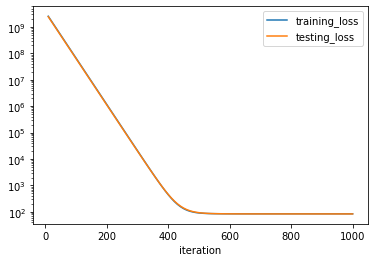

In [8]:
(x_tr, y_tr), (x_te, y_te) = tf.keras.datasets.boston_housing.load_data()
y_tr, y_te = map(lambda x: np.expand_dims(x, -1), (y_tr, y_te))
x_tr, y_tr, x_te, y_te = map(lambda x: tf.cast(x, tf.float32), (x_tr, y_tr, x_te, y_te))

@tf.function
def train_step(model, x, y):
    with tf.GradientTape() as tape:
        loss = tf.reduce_mean(tf.square(y - model(x)))
    gradients = tape.gradient(loss, model.variables)
    for g, v in zip(gradients, model.variables):
        v.assign_add(tf.constant([-0.01], dtype=tf.float32) * g)
    return loss

@tf.function
def test_step(model, x, y):
    return tf.reduce_mean(tf.square(y - model(x)))

def train(model, n_epochs=1000, his_freq=10):   #his_freq: frequency of saving history
    history = []
    for iteration in range(1, n_epochs + 1):
        tr_loss = train_step(model, x_tr, y_tr)
        te_loss = test_step(model, x_te, y_te)
        if not iteration % his_freq:
            history.append({
            'iteration': iteration,\
            'training_loss': tr_loss.numpy(),\
            'testing_loss': te_loss.numpy()
            })
    return model, pd.DataFrame(history)

mlp, mlp_history = train(MLP(4, 1))
pprint(mlp_history.tail())
ax = mlp_history.plot(x='iteration', kind='line', logy=True)
fig = ax.get_figure()
# fig.savefig('ch3_plot_1.png')

It may seem that our model has nicely converged. Since there is not much a discrepancy
between training set and testing set performance. However if we look at the numbers
more closely, they are pretty bad. A simple constant prediction have MSE around 83.
What could go wrong? We will look at other optimizers in the next chapter.

### Optimizers

#### Gradient Descent

In [10]:
class GradientDescent(object):
    def __init__(self, lr=.01):
        self._lr = tf.Variable(lr, dtype=tf.float32)
    def apply_gradients(self, grads_and_vars):
        for grad, var in grads_and_vars:
            update = - self._lr * grad
            var.assign_add(update)

With this optimizer class, our training code is becoming more modularized.

In [11]:
@tf.function
def train_step(model, optimizer, x, y):
    with tf.GradientTape() as tape:
        loss = tf.reduce_mean(tf.square(y - model(x)))
    gradients = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(zip(gradients, model.variables))
    return loss

@tf.function
def test_step(model, x, y):
    return tf.reduce_mean(tf.square(y - model(x)))

def train(model, optimizer, n_epochs=10000, his_freq=100):
    history = []
    for epoch in range(1, n_epochs + 1):
        tr_loss = train_step(model, optimizer, x_tr, y_tr)
        te_loss = test_step(model, x_te, y_te)
        if not epoch % his_freq:
            history.append({'epoch': epoch,
            'training_loss': tr_loss.numpy(),
            'testing_loss': te_loss.numpy()})
    return model, pd.DataFrame(history)

Recall that from the end of last chapter, our model is no better than a constant function.
Wondering if learning rate of the optimizer has anything to do with it. Let's to code up
some experiments on how learning rate affects the training progress.

lr
1.000000e-09    1188.702759
1.000000e-08     131.820633
1.000000e-07      72.296074
1.000000e-06      64.942604
1.000000e-05     445.525879
1.000000e-04      96.993584
1.000000e-03      83.711510
Name: testing_loss, dtype: float64


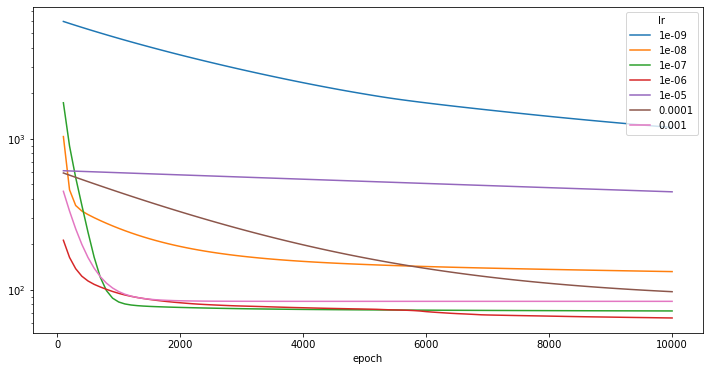

In [12]:
def lr_experiments(learning_rates):
    experiments = []
    for lr in learning_rates:
        model, history = train(MLP(4, 1), GradientDescent(lr))
        history['lr'] = lr
        experiments.append(history)
    experiments = pd.concat(experiments, axis=0)
    return experiments

experiments = lr_experiments(learning_rates=[10 ** -i for i in range(3, 10)])
ax = experiments.\
    pivot(index='epoch', columns='lr', values='testing_loss').\
    plot(kind='line', logy=True, figsize=(12, 6))

# ax.get_figure().savefig('ch4_plot_1.png')
print(experiments.groupby('lr')['testing_loss'].min())

We see that with learning rate 1e-6, we can finally beat the naive baseline model, which is
a constant. Wait a second, in what situation would our network be equivalent to a
constant? Only if the activations are mostly zeros, and thus the model would almost
always output the bias term from the last layer. Let's see if that is the case.

In [13]:
model, history = train(MLP(4, 1), GradientDescent(1e-3))
print(model.layers[0](x_te))
print(model.layers[0](x_te) @ model.layers[1].variables[0])
print(model.layers[1].variables[1])

tf.Tensor(
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]

Indeed, with learning rate 1e-3 our network basically collapsed to a bias term. In this case,
the initial gradients exploded, if the learning rate is also very big, it can kill almost all the
units immediately. So, we would need to either reduce the learning rate or apply some
kind of control of the gradient values. Normalize the gradient is a good addition we should
add to the gradient descent optimizer.

41.942726135253906


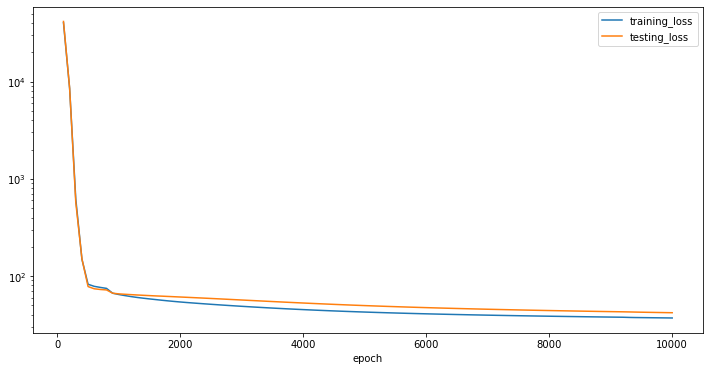

In [14]:
class GradientDescent(object):
    def __init__(self, lr=.01, clipnorm=None):
        self._lr = tf.Variable(lr, dtype=tf.float32)
        self.clipnorm = clipnorm
    def apply_gradients(self, grads_and_vars):
        for grad, var in grads_and_vars:
            if self.clipnorm: grad = tf.clip_by_norm(grad, self.clipnorm)
            update = - self._lr * grad
            var.assign_add(update)

model, history = train(MLP(4, 1), GradientDescent(1e-3, clipnorm=2))
ax = history.plot(x='epoch', logy=True, figsize=(12, 6))
# ax.get_figure().savefig('ch4_plot_2.png')
print(history['testing_loss'].min())

Now, we tried training our model again, this time, we normalize the gradients to have l2
norm equal to a small number 2, and indeed we got much better result even with the
previously problematic learning rate value 1e-3.

`tf.clip_by_norm` https://www.tensorflow.org/api_docs/python/tf/clip_by_norm

In [15]:
some_nums = tf.constant([[1, 2, 3, 4, 5]], dtype=tf.float32)
tf.clip_by_norm(some_nums, 2.0).numpy()

array([[0.26967996, 0.5393599 , 0.80903983, 1.0787199 , 1.3483998 ]],
      dtype=float32)

#### Stochastic Gradient Descent

Yet another problem with the above gradient descent optimization is that it uses the full
dataset every time it needs to do a parameter update. It can be very both very slow and
memory hungry. A quick fix is to use small samples of the data to get estimates of the
gradients and perform much more frequent updates. This is called stochastic gradient
descent(SGD).

To train our model with SGD, we don't need to modify our optimizer class. Instead, we
need to modify the training code to include sampling. To make life a bit easier, we can
wrap the data tensors into iterators.

In [19]:
class Dataset(object):
    def __init__(self, tensors, batch_size=32, shuffle=True):
        self.tensors = tensors if isinstance(tensors, (list, tuple)) else (tensors, )
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.total = tensors[0].shape[0]
        assert all(self.total == tensor.shape[0] for tensor in self.tensors), 'Tensors should have matched length'
        self.n_steps = self.total // self.batch_size
        self._indices = tf.range(self.total)
        
    def __iter__(self):
        self._i = 0
        if self.shuffle:
            self._indices = tf.random.shuffle(self._indices)
        return self

    def __next__(self):
        if self._i >= self.n_steps:
            raise StopIteration
        else:
            start = self._i * self.batch_size
            end = start + self.batch_size
            indices = self._indices[start: end]
            samples = (tf.gather(tensor, indices) for tensor in self.tensors)
            self._i += 1
            return samples

With this `Dataset` class, we can make very small change to the training code.

83.70316314697266


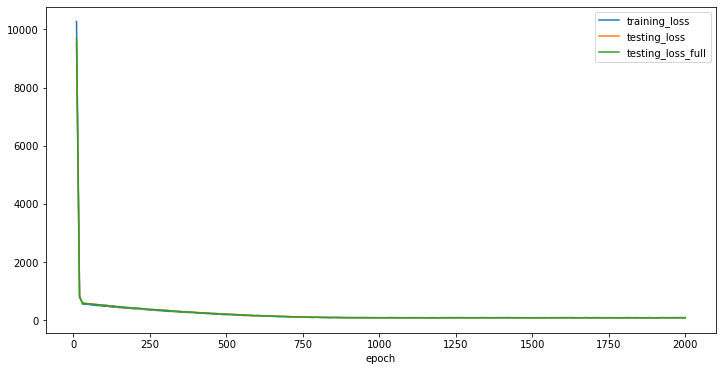

In [20]:
train_dataset = Dataset((x_tr, y_tr))
test_dataset = Dataset((x_te, y_te))
def train(model, optimizer, n_epochs, batch_size=32, his_freq=10):
    history = []
    for epoch in range(1, n_epochs + 1):
        tr_loss = []
        for x, y in train_dataset:
            tr_loss.append(train_step(model, optimizer, x, y).numpy())
        te_loss = []
        for x, y in test_dataset:
            te_loss.append(test_step(model, x, y).numpy())
        te_loss_full = test_step(model, x_te, y_te)
        if not epoch % his_freq:
            history.append({'epoch': epoch,
            'training_loss': np.mean(tr_loss),
            'testing_loss': np.mean(te_loss),
            'testing_loss_full': te_loss_full.numpy()}
            )
    return model, pd.DataFrame(history)

model, history = train(MLP(4, 1), GradientDescent(1e-3, 2), n_epochs=2000)
ax = history.plot(x='epoch', kind='line', figsize=(12, 6))
# ax.get_figure().savefig('ch4_plot_3.png')
print(history.testing_loss_full.min())

We can see that training with small batches of random samples, the trajectory of loss
values becomes a bit zig-zag in shape, but still follows the similar path as previously when
we train with full dataset.

#### Momentum

If we look at the learning curve, we see that after the initial huge drop, the progress
becomes very slow but steady. Wondering if there is something can help us accelerate
the progress? One improvement made to Gradient Descent is to accelerate it by builds up
the velocity, which equals to use an exponential moving average(EMA) version of the
gradients.

In [21]:
class Momentum(object):
    def __init__(self, lr=.01, beta=.9, clipnorm=None):
        self._lr = tf.Variable(lr, dtype=tf.float32)
        self._beta = tf.Variable(beta, dtype=tf.float32)
        self.clipnorm = clipnorm
        
    def init_moments(self, var_list):
        self._moments = {var._unique_id: tf.Variable(tf.zeros_like(var))for var in var_list}
    
    def apply_gradients(self, grads_and_vars):
        for grad, var in grads_and_vars:
            if self.clipnorm: grad = tf.clip_by_norm(grad, self.clipnorm)
            m = self._moments[var._unique_id]
            m.assign(self._beta * m - self._lr * grad)
            update = m
            var.assign_add(m)

What added a set of moment variables to accumulates gradients, and we used a mapping
to keep track of the association between variables and the accumulators.

28.95368003845215


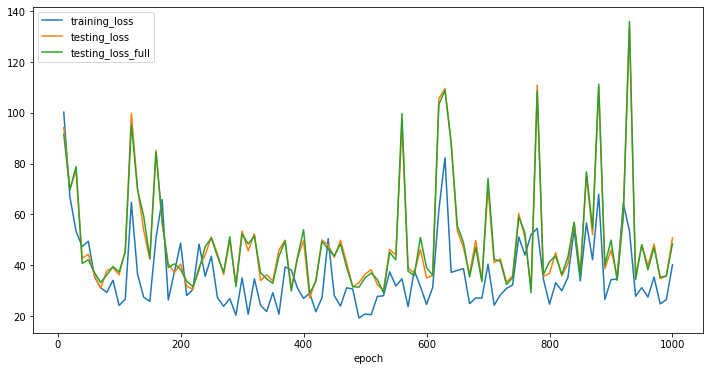

In [22]:
model = MLP(4, 1)
model.build(input_shape=(32,13))
optimizer = Momentum(lr=1e-3, beta=.98, clipnorm=2)
optimizer.init_moments(model.variables)
model, history = train(model, optimizer, n_epochs=1000)
ax = history.plot(x='epoch', kind='line', figsize=(12, 6))
# ax.get_figure().savefig('ch4_plot_4.png')
print(history.testing_loss_full.min())

#### Second Moment

As with the first moment of the gradients, second moment were also made use to guide
optimization. The Adam optimizer
<font color=red> Formula here </font>

In a nutshell, the optimizer uses two sets of accumulators to keep track of the first two
moments of the gradients. <font color=red>The algorithm uses the second moment to scale the first
moment, intuitively this works like a signal to noise ratio adjustment, with the first moment
be the signal and the second moment be noise.</font> Since all the operations are elementwise,
this signal to noise treatment is customized for each and every parameter in the model, so
effectively every parameter has its own learning rate.

In [23]:
class Adam(object):
    def __init__(self, lr=.01, beta_1=.9, beta_2=.999, epsilon=1e-8, clipnorm=None):
        self._lr = tf.Variable(lr, dtype=tf.float32)
        self._beta_1 = tf.Variable(beta_1, dtype=tf.float32)
        self._beta_2 = tf.Variable(beta_2, dtype=tf.float32)
        self._epsilon = tf.constant(epsilon, dtype=tf.float32)
        self.clipnorm = clipnorm
        self._t = tf.Variable(0, dtype=tf.float32)

    def init_moments(self, var_list):
        self._m = {var._unique_id: tf.Variable(tf.zeros_like(var))for var in var_list}
        self._v = {var._unique_id: tf.Variable(tf.zeros_like(var))for var in var_list}

    def apply_gradients(self, grads_and_vars):
        self._t.assign_add(tf.constant(1., self._t.dtype))
        for grad, var in grads_and_vars:
            if self.clipnorm: grad = tf.clip_by_norm(grad, self.clipnorm)
            m = self._m[var._unique_id]
            v = self._v[var._unique_id]
            m.assign(self._beta_1 * m + (1. - self._beta_1) * grad)
            v.assign(self._beta_2 * v + (1. - self._beta_2) * tf.square(grad))
            lr = self._lr * tf.sqrt(1 - tf.pow(self._beta_2, self._t))/ (1 - tf.pow(self._beta_1, self._t))
            update = -lr * m / (tf.sqrt(v) + self._epsilon)
            var.assign_add(update)

Let's see if we can get better result with Adam.

22.847196578979492


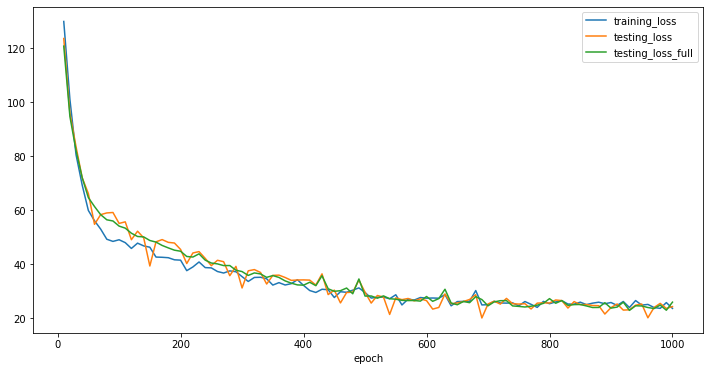

In [24]:
model = MLP(4, 1)
model.build(input_shape=(32,13))
optimizer = Adam(lr=1e-3, beta_1=.9, beta_2=.999, epsilon=1e-8, clipnorm=2)
optimizer.init_moments(model.variables)

model, history = train(model, optimizer, n_epochs=1000)
ax = history.plot(x='epoch', kind='line', figsize=(12, 6))
# ax.get_figure().savefig('ch4_plot_5.png')
print(history.testing_loss_full.min())

Adam is pretty much the default first choice of optimizer for most people on most
problems. Since we have already organically coded it up, we can now take a look at how
we can go about to do it by sub classing the `tf.keras.optimizers.Optimizer`.

To implement a custom `tf.keras` optimizer, there are a few methods we need to
implement:
- 1. `_resource_apply_dense()` - this is the method used to perform parameter
updates with dense gradient tensors.
- 2. `_resource_apply_sparse()` - above but works with sparse gradient tensors.
- 3. `_create_slots()` - optionally if the optimizer require more variables. If the
optimizer only uses gradients and variables(like SGD), this is not needed.
- 4. `_get_config()` - optionally for save(serialize) / load(de-serialize) the optimizer with
hyperparameters.

our `init_moments()` method roughly corresponds to the `_create_slots()` and our
`apply_gradients()` method needs to be moved to `_resource_apply_dense()`. And
since we have quite a few hyperparameters, we need to code up the `_get_config()`
method too.

In [28]:
class Adam(tf.keras.optimizers.Optimizer):
    def __init__(self, learning_rate=.001, beta_1=.9, beta_2=.999, epsilon=1e-8, name='Adam', **kwargs):
        super().__init__(name, **kwargs)
        self._set_hyper('learning_rate', kwargs.get('lr', learning_rate))
        self._set_hyper('beta_1', beta_1)
        self._set_hyper('beta_2', beta_2)
        self.epsilon = epsilon or tf.keras.backend.epsilon()
    
    def _create_slots(self, var_list):
        for var in var_list:
            self.add_slot(var, 'm')
        for var in var_list:
            self.add_slot(var, 'v')
    
    def _resource_apply_dense(self, grad, var):
        dtype = var.dtype.base_dtype
        t = tf.cast(self.iterations + 1, dtype)
        lr = self._decayed_lr(dtype)
        beta_1 = self._get_hyper('beta_1', dtype)
        beta_2 = self._get_hyper('beta_2', dtype)
        epsilon = tf.convert_to_tensor(self.epsilon, dtype)
        m = self.get_slot(var, 'm')
        v = self.get_slot(var, 'v')
        m = m.assign(beta_1 * m + (1. - beta_1) * grad)
        v = v.assign(beta_2 * v + (1. - beta_2) * tf.square(grad))
        lr = lr * tf.sqrt(1 - tf.pow(beta_2, t)) / (1 - tf.pow(beta_1,t))
        update = -lr * m / (tf.sqrt(v) + epsilon)
        var_update = var.assign_add(update)
        updates = [var_update, m, v]
        return tf.group(*updates)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'learning_rate': self._serialize_hyperparameter('learning_rate'),\
            'beta_1': self._serialize_hyperparameter('beta_1'),\
            'beta_2': self._serialize_hyperparameter('beta_2'),\
            'epsilon': self.epsilon,\
            'total_steps': self._serialize_hyperparameter('total_steps'
            ),
            })
        return config

Time to see how does it compares.

In [30]:
model = MLP(4, 1)
optimizer = Adam(lr=1e-3, beta_1=.9, beta_2=.999, epsilon=1e-8)
model, history = train(model, optimizer, n_epochs=1000)
ax = history.plot(x='epoch', kind='line', figsize=(12, 6))
# ax.get_figure().savefig('ch4_plot_5.png')
print(history.testing_loss_full.min())

ValueError: in user code:

    <ipython-input-11-42c1a8acf7a7>:6 train_step  *
        optimizer.apply_gradients(zip(gradients, model.variables))
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:604 apply_gradients  **
        self._create_all_weights(var_list)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:781 _create_all_weights
        _ = self.iterations
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:788 __getattribute__
        return super(OptimizerV2, self).__getattribute__(name)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:921 iterations
        self._iterations = self.add_weight(
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:1122 add_weight
        variable = self._add_variable_with_custom_getter(
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/training/tracking/base.py:805 _add_variable_with_custom_getter
        new_variable = getter(
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer_utils.py:130 make_variable
        return tf_variables.VariableV1(
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/ops/variables.py:260 __call__
        return cls._variable_v1_call(*args, **kwargs)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/ops/variables.py:206 _variable_v1_call
        return previous_getter(
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/ops/variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/eager/def_function.py:730 invalid_creator_scope
        raise ValueError(

    ValueError: tf.function-decorated function tried to create variables on non-first call.


From now on, we will just use `tf.keras.optimizers.Adam` whenever we are going to
train a model.

So we spent a lot time in optimizers in this chapter, along the way we looked at the effect
of learning rate, normalization of the gradient values to prevent network collapse, and
looked into the black box of how a few classic optimizer works. And we see all these has
a positive impact on the training result, as our network is fitted much better compare to at
the end of last chapter. Next we will look into Loss functions.

http://www.080910t.com/wp-content/uploads/2019/11/TFW.pdf

https://www.tensorflow.org/tutorials/quickstart/beginner

http://users.diag.uniroma1.it/~alcorlab/sites/default/files/allegati/Tensorflow%20_%20Tensorflow%202.0_0.pdf